In [3]:
%matplotlib inline
import torch
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import operator

### Getting Started

Tensors are similar to numpy's ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing.

In [2]:
x = torch.Tensor(5, 3); x


 3.3268e-28  4.5574e-41  5.9455e-11
 3.0838e-41         nan  4.5574e-41
 4.4721e+21  1.6647e-41  6.7262e-44
 0.0000e+00  6.7262e-44  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00
[torch.FloatTensor of size 5x3]

In [3]:
x = torch.rand(5, 3); x


 0.2233  0.7956  0.4220
 0.2330  0.7031  0.2786
 0.7273  0.5527  0.5552
 0.7430  0.0426  0.2588
 0.5630  0.4180  0.5197
[torch.FloatTensor of size 5x3]

In [4]:
x.size()

torch.Size([5, 3])

In [5]:
y = torch.rand(5, 3)

In [ ]:
x + y

In [ ]:
torch.add(x, y)

In [ ]:
result = torch.Tensor(5, 3)
torch.add(x, y, out=result)

In [ ]:
# anything ending in '_' is an in-place operation
y.add_(x) # adds x to y in-place

In [ ]:
# standard numpy-like indexing with all bells and whistles
x[:,1]

### Numpy Bridge

The torch Tensor and numpy array will share their underlying memory locations, and changing one will change the other.

#### Converting torch Tensor to numpy Array

In [ ]:
a = torch.ones(5)
a

In [ ]:
b = a.numpy()
b

In [ ]:
a.add_(1)
print(a)
print(b) # see how the numpy array changed in value

#### Converting numpy Array to torch Tensor

In [ ]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b) # see how changing the np array changed the torch Tensor automatically

### CUDA Tensors

Tensors can be moved onto GPU using the `.cuda` function.

In [ ]:
x = x.cuda()
y = y.cuda()

x+y

## Autograd: automatic differentiation

Central to all neural networks in PyTorch is the `autograd` package.

The `autograd` package provides automatic differentiation for all operations on Tensors.  
It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different. 

`autograd.Variable` is the central class of the package. 
It wraps a Tensor, and supports nearly all of operations defined on it. Once you finish your computation you can call `.backward()` and have all the gradients computed automatically.

You can access the raw tensor through the `.data` attribute, while the gradient w.r.t. this variable is accumulated into `.grad`.

If you want to compute the derivatives, you can call `.backward()` on a `Variable`. 

In [ ]:
x = Variable(torch.ones(2, 2), requires_grad = True); x

In [ ]:
y = x + 2; y

In [ ]:
y.creator

In [ ]:
z = y * y * 3; z

In [ ]:
out = z.mean(); out

In [ ]:
# You never have to look at these in practice - this is just showing how the
#   computation graph is stored
print(out.creator.previous_functions[0][0])
print(out.creator.previous_functions[0][0].previous_functions[0][0])

In [ ]:
out.backward()

In [ ]:
# d(out)/dx
x.grad

You should have got a matrix of `4.5`.

Because PyTorch is a dynamic computation framework, we can take the gradients of all kinds of interesting computations, even loops!

In [ ]:
x = torch.randn(3)
x = Variable(x, requires_grad = True)

In [ ]:
y = x * 2
while y.data.norm() < 1000:
    y = y * 2

In [ ]:
y

In [ ]:
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

In [ ]:
x.grad

## Neural Networks

Neural networks can be constructed using the `torch.nn` package.

An `nn.Module` contains layers, and a method `forward(input)`that returns the `output`.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120) # like keras' Dense()
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        return reduce(operator.mul, x.size()[1:])

In [ ]:
net = Net(); net

You just have to define the `forward` function, and the `backward` function (where gradients are computed) is automatically defined for you using `autograd`.

The learnable parameters of a model are returned by `net.parameters()`

In [ ]:
net.cuda();

In [ ]:
params = list(net.parameters())
len(params), params[0].size()

The input to the forward is a `Variable`, and so is the output.

In [ ]:
input = Variable(torch.randn(1, 1, 32, 32)).cuda()
out = net(input); out

In [ ]:
net.zero_grad() # zeroes the gradient buffers of all parameters
out.backward(torch.randn(1, 10).cuda()) # backprops with random gradients

A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target. There are [several different loss functions under the nn package](http://pytorch.org/docs/nn.html#loss-functions). A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

In [ ]:
output = net(input)
target = Variable(torch.range(1, 10)).cuda()  # a dummy target, for example
loss = nn.MSELoss()(output, target); loss

Now, if you follow `loss` in the backward direction, using it's `.creator` attribute, you will see a graph of computations that looks like this:

```
input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d  
      -> view -> linear -> relu -> linear -> relu -> linear 
      -> MSELoss
      -> loss
```

So, when we call `loss.backward()`, the whole graph is differentiated w.r.t. the loss, and all Variables in the graph will have their `.grad` Variable accumulated with the gradient.
       

In [ ]:
# now we shall call loss.backward(), and have a look at gradients before and after
net.zero_grad() # zeroes the gradient buffers of all parameters
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr = 0.01)

# in your training loop:
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = nn.MSELoss()(output, target)
loss.backward()
optimizer.step() # Does the update

## Example complete process

For vision, there is a package called `torch.vision`, that 
has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images.

For this tutorial, we will use the CIFAR10 dataset. 

### Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`
1. Define a Convolution Neural Network
1. Define a loss function
1. Train the network on the training data
1. Test the network on the test data

### 1. Loading and normalizing CIFAR10

Using `torch.vision`, it's extremely easy to load CIFAR10. 

In [1]:
import torchvision
from torchvision import transforms, datasets

In [4]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, 
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, 
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
    plt.imshow(np.transpose((img / 2 + 0.5).numpy(), (1,2,0)))

 frog plane  bird   dog


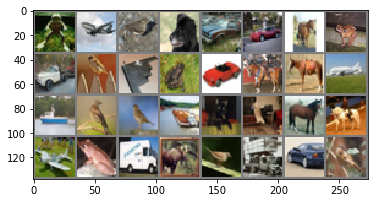

Process Process-3:
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()

In [25]:
# show some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

### 2. Define a Convolution Neural Network

In [7]:
images.size()

torch.Size([32, 3, 32, 32])

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
#         (W−F+2P)/S+1
#         (32 - 5) + 1 = 28 
#         (W - f) / S + 1
#         (30 - 2) / 2 + 1 (max pool) = 14

        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(32, 32, 3)
        # (14 - 3) + 1 = 12
        # max pool / 2 = 6
        self.dense1 = torch.nn.Linear(32 * 6 * 6, 120)
        self.dense2 = torch.nn.Linear(120, 84)
        self.dense3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.size())
        x = self.flatten(x)
#         print(x.size())
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return x
        
    def flatten(self, input):
        return input.view(input.size(0), -1)
net = Net().cuda()

In [93]:
# list(net.parameters())
net

Net (
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dense1): Linear (1152 -> 120)
  (dense2): Linear (120 -> 84)
  (dense3): Linear (84 -> 10)
)

### 2. Define a Loss function and optimizer

In [94]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adagrad(net.parameters())

### 3. Train the network

This is when things start to get interesting.

We simply have to loop over our data iterator, and feed the inputs to 
the network and optimize

In [99]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0
    for i,data in enumerate(iter(trainloader)):
        images, labels = data
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 200 == 199: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 200))
            running_loss = 0.0
        
        

[1,   200] loss: 0.097
[1,   400] loss: 0.099
[1,   600] loss: 0.100
[1,   800] loss: 0.098
[1,  1000] loss: 0.097
[1,  1200] loss: 0.097
[1,  1400] loss: 0.097
[2,   200] loss: 0.095
[2,   400] loss: 0.093
[2,   600] loss: 0.098
[2,   800] loss: 0.097
[2,  1000] loss: 0.093
[2,  1200] loss: 0.097
[2,  1400] loss: 0.096


We will check what the model has learned by predicting the class label, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

First, let's display an image from the test set to get familiar.

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
' '.join('%5s'%classes[labels[j]] for j in range(4))

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
outputs = net(Variable(images).cuda())
_, predicted = torch.max(outputs.data, 1)
' '.join('%5s'% classes[predicted[j][0]] for j in range(4))

The results seem pretty good. Let us look at how the network performs on the whole dataset.

In [ ]:
correct,total = 0,0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images).cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).